# Load data from [here](https://www.kaggle.com/c/bike-sharing-demand)

In [1]:
import numpy as np
import pandas as pd
from data.utils import split_data

In [3]:
# Load data.
df = pd.read_table('datasets/bike.csv', sep=',',
                   header=0, index_col=None)
columns = list(df.columns)

# Split datetime column.
df['datetime'] = pd.to_datetime(df['datetime'])
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour

# Remove datetime column.
df = df.drop('datetime', axis=1)

# Reorder columns.
df = df[['year', 'month', 'day', 'hour'] + columns[1:]]

# Feature names.
features = df.columns[:-3]

In [3]:
# Split data, with total count serving as regression target.
train, val, test = split_data(df.values, seed=123,
                              val_portion=0.1,
                              test_portion=0.1)
Y_train = train[:, -1][:, np.newaxis]
Y_val = val[:, -1][:, np.newaxis]
Y_test = test[:, -1][:, np.newaxis]
train = train[:, :-3]
val = val[:, :-3]
test = test[:, :-3]

# Train model

In [4]:
import torch
import torch.nn as nn
from models.mlp import MLP
from models.train_models import Train, validate
from data.utils import TabularDataset
from torch.utils.data import DataLoader, RandomSampler, BatchSampler

In [5]:
# Prepare data loaders.
train_set = TabularDataset(train, Y_train)
val_set = TabularDataset(val, Y_val)
train_loader = DataLoader(
    train_set, batch_sampler=BatchSampler(
        RandomSampler(train_set, replacement=True),
        batch_size=512, drop_last=False))
val_loader = DataLoader(val_set, batch_size=len(val_set))

In [6]:
# Set up model.
model = MLP(input_size=train.shape[1],
            output_size=1,
            hidden=[256, 256, 256],
            activation='elu').to(device=torch.device('cuda'))

# Train model.
trainer = Train(model)
trainer.train(train_loader,
              val_loader,
              lr=1e-3,
              mbsize=64,
              nepochs=250,
              loss_fn=nn.MSELoss(),
              check_every=250,
              lookback=50)

----------Epoch = 1----------
Train performance = 21259.1066
Val performance = 23510.5684
----------Epoch = 2----------
Train performance = 20556.9416
Val performance = 21777.5391
----------Epoch = 3----------
Train performance = 35492.3346
Val performance = 20766.3066
----------Epoch = 4----------
Train performance = 26324.9866
Val performance = 20900.8926
----------Epoch = 5----------
Train performance = 20183.7873
Val performance = 21724.1211
----------Epoch = 6----------
Train performance = 25354.8718
Val performance = 20436.7832
----------Epoch = 7----------
Train performance = 18083.8861
Val performance = 21336.9590
----------Epoch = 8----------
Train performance = 23448.6589
Val performance = 20920.8574
----------Epoch = 9----------
Train performance = 19811.2273
Val performance = 20301.9375
----------Epoch = 10----------
Train performance = 17538.5535
Val performance = 20902.4258
----------Epoch = 11----------
Train performance = 22143.5356
Val performance = 22496.5312
--------

----------Epoch = 93----------
Train performance = 11052.5591
Val performance = 6282.5801
----------Epoch = 94----------
Train performance = 4613.4645
Val performance = 5154.0396
----------Epoch = 95----------
Train performance = 5812.7018
Val performance = 5910.4268
----------Epoch = 96----------
Train performance = 10854.1976
Val performance = 8152.1602
----------Epoch = 97----------
Train performance = 5548.1001
Val performance = 5328.5464
----------Epoch = 98----------
Train performance = 4651.8264
Val performance = 5174.4014
----------Epoch = 99----------
Train performance = 5407.4279
Val performance = 4955.2153
----------Epoch = 100----------
Train performance = 6109.6182
Val performance = 5451.5176
----------Epoch = 101----------
Train performance = 5460.1443
Val performance = 5610.9155
----------Epoch = 102----------
Train performance = 5603.8303
Val performance = 5899.7471
----------Epoch = 103----------
Train performance = 6929.0925
Val performance = 5086.4331
----------Epoch

----------Epoch = 185----------
Train performance = 3659.5795
Val performance = 4974.5591
----------Epoch = 186----------
Train performance = 5454.2194
Val performance = 6557.5840
----------Epoch = 187----------
Train performance = 2692.4376
Val performance = 5218.2778
----------Epoch = 188----------
Train performance = 4407.6432
Val performance = 4866.5449
----------Epoch = 189----------
Train performance = 7333.0883
Val performance = 5980.5923
----------Epoch = 190----------
Train performance = 3545.1356
Val performance = 5104.2295
----------Epoch = 191----------
Train performance = 5278.3824
Val performance = 4890.3228
----------Epoch = 192----------
Train performance = 5991.8533
Val performance = 5126.9585
----------Epoch = 193----------
Train performance = 2869.7924
Val performance = 5384.2671
----------Epoch = 194----------
Train performance = 4604.4346
Val performance = 5954.8140
----------Epoch = 195----------
Train performance = 5832.0856
Val performance = 5107.1284
----------

In [7]:
# Base rate performance.
mean = np.mean(Y_train)
print('Base rate MSE = {:.3f}'.format(
    np.mean((mean - Y_val) ** 2)))

# Model performance.
print('Model MSE = {:.3f}'.format(
    validate(model, val_loader, nn.MSELoss())))

Base rate MSE = 32212.883
Model MSE = 4684.971


# Calculate feature importance

In [8]:
from importance import sage
from importance.utils import MarginalImputation
import matplotlib.pyplot as plt

In [9]:
# Create dataset.
dataset = TabularDataset(test, Y_test)

# Imputation module for held out features.
imputation = MarginalImputation(train)

# Run SAGE.
scores = sage.permutation_sampling(
    model,
    dataset,
    imputation,
    'mse',
    n_samples=2 ** 12,
    m_samples=512,
    batch_size=2 ** 10,
    bar=True)

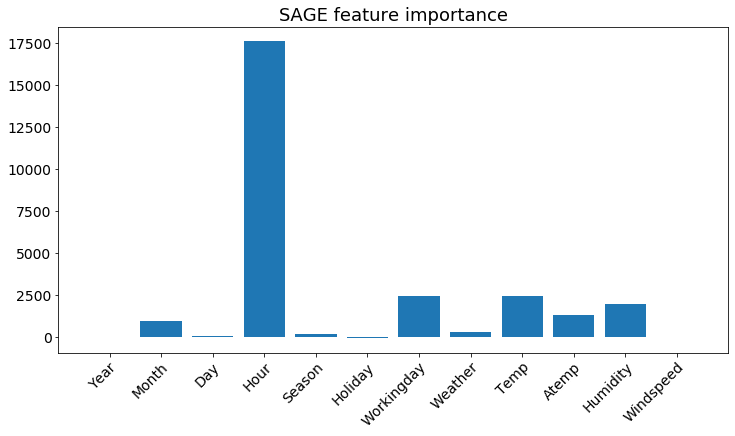

In [10]:
# Visualize feature importance.
plt.figure(figsize=(12, 6))

plt.bar(np.arange(len(scores)), scores)
plt.xticks(np.arange(len(scores)), map(str.title, features),
           rotation=45, ha='right', rotation_mode='anchor')
plt.tick_params('both', labelsize=14)
plt.title('SAGE feature importance', fontsize=18)

plt.show()